In [3]:
import gc
import numpy as np
import math
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [ ]:
song_cols = ['song_id', 'song_length', 'language']
songs = pd.read_csv('../Data/songs.csv', usecols = song_cols)

members = pd.read_csv('../Data/members.csv')
members = members.drop(['bd', 'gender','registration_init_time','expiration_date'], axis=1)

joined = pd.read_csv('../New_Data/joined.csv')
duplicated_idx = joined.duplicated(subset='song_id', keep='first')
joined = joined[~duplicated_idx]

In [ ]:
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')

In [ ]:
songs_new = songs.merge(joined, on='song_id', how='left')

In [ ]:
train = train.merge(songs_new, on='song_id', how='left')
test = test.merge(songs_new, on='song_id', how='left')

#members['registration_year'] = members['registration_init_time'].apply(lambda x: int(str(x)[0:4]))
#members['registration_month'] = members['registration_init_time'].apply(lambda x: int(str(x)[4:6]))
#members['registration_date'] = members['registration_init_time'].apply(lambda x: int(str(x)[6:8]))

#members['expiration_year'] = members['expiration_date'].apply(lambda x: int(str(x)[0:4]))
#members['expiration_month'] = members['expiration_date'].apply(lambda x: int(str(x)[4:6]))
#members['expiration_date'] = members['expiration_date'].apply(lambda x: int(str(x)[6:8]))
#members = members.drop(['registration_init_time'], axis=1)

train = train.merge(members, on='msno', how='left')
test = test.merge(members, on='msno', how='left')

train = train.fillna(-2)
test = test.fillna(-2)

In [ ]:
cols = list(train.columns)
cols.remove('target')

for col in tqdm(cols):
    if train[col].dtype == 'object':
        train[col] = train[col].apply(str)
        test[col] = test[col].apply(str)

        le = LabelEncoder()
        train_vals = list(train[col].unique())
        test_vals = list(test[col].unique())
        le.fit(train_vals + test_vals)
        train[col] = le.transform(train[col])
        test[col] = le.transform(test[col])

In [ ]:
X = np.array(train.drop(['target'], axis=1))
Y = train['target'].values

X_test = np.array(test.drop(['id'], axis=1))
Y_test = test['id'].values

In [ ]:
cols_name = list(train.columns)
X_new = X

max_vals = X_new.max(axis = 0).transpose()
min_vals = X_new.min(axis = 0).transpose()
mean_vals = np.mean(X_new, axis = 0).transpose()

In [ ]:
#training set
X_new = X_new - mean_vals
X_new = X_new / (max_vals - min_vals)
X_new = np.around(X_new,decimals = 2)

In [ ]:
#testing set
X_new_test = X_test - mean_vals
X_new_test = X_new_test / (max_vals - min_vals)
X_new_test = np.around(X_new_test,decimals = 2)

In [ ]:
del X; 
del members, songs, joined;
del train, test;
gc.collect();

In [1]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
input_shape = 50 #X_new.shape[1]

Using TensorFlow backend.


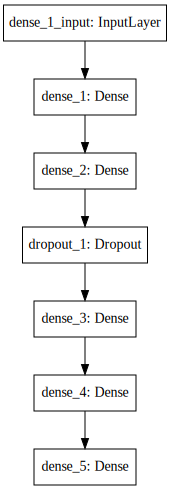

In [4]:
training = True
model = Sequential([
        Dense(units=1024, kernel_initializer='uniform', input_dim=input_shape, activation='relu'),
        Dense(units=512, kernel_initializer='uniform', activation='relu'),
        Dropout(0.25),
        Dense(128, kernel_initializer='uniform', activation='relu'),
        Dense(64, kernel_initializer='uniform', activation='relu'),
        Dense(1, kernel_initializer='uniform', activation='sigmoid')
    ])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
if training:
    model.fit(X_new, Y, batch_size=128, epochs=20, validation_split=0.1, validation_data=None, shuffle=True)
    model.save('../Models/dnn_preprocessed.h5')
else:
    weights = '../Models/dnn_preprocessed.h5'
    model.load_weights(weights)

In [ ]:
predicted = model.predict(X_new_test, batch_size=128, verbose=0)

In [ ]:
headers = ['id', 'target']
new_test = pd.DataFrame(columns=headers)
new_test['id'] = Y_test
new_test['target'] = predicted

duplicated_idx = new_test.duplicated(subset='id', keep='first')
new_test = new_test[~duplicated_idx]
new_test['target'] = new_test['target'].apply(lambda x: 1 if x>0.5 else 0)
new_test.to_csv('submission_dnn.csv', index=False, header=['id', 'target'])